# Heat Pump Model based on Manufacturer's COP specs

In [1]:
import math
from pprint import pprint
from glob import glob
import os

import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *

from IPython.core.debugger import set_trace
 
# Show Plots in the Notebook
%matplotlib inline
 
rcParams['figure.figsize']= (12, 7)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
df = pd.read_excel('hp_ratings.xlsx', skiprows=3)
len(df)

117

In [3]:
for c in df.columns:
    if not c.startswith('C'):
        print(c)

ahri
out_model
in_model
hspf
cap_min_47
cap_rated_47
cap_max_47
cop_min_47
cop_rated_47
cop_max_47
cap_min_17
cap_rated_17
cap_max_17
cop_min_17
cop_rated_17
cop_max_17
cap_min_5
cap_max_5
cop_min_5
cop_max_5
dbt_cold
cap_min_cold
cap_max_cold
cop_min_cold
cop_max_cold


In [4]:
def interp(lo, hi, pct):
    """Returns a value 'pct' of the way between 'lo' and 'hi'
    """
    return lo + (hi - lo) * pct


class HPmodel(object):
    
    def __init__(self):
        # some default values
        # normally you would set these using standard attribute access
        self.oil_price = 2.7
        self.oil_btu_per_gal = 135000.0
        self.oil_effic = 0.8
        self.elec_price = 0.16
        self.balance_temp = 60.0   # deg F
        self.base_load = 0.0       # load at balance temperature and above
        self.load_slope = 800.0    # Btu/hour per deg F
        
    @property
    def heat_pump(self):
        return self._heat_pump
        
    @property
    def heat_pump_model(self):
        if hasattr(self, 'heat_pump'):
            hp = self.heat_pump
            return '%s / %s / %s' % (hp.out_model, hp.in_model, hp.ahri)
        else:
            return 'None'
        
    @heat_pump.setter
    def heat_pump(self, value):
        self._heat_pump = value
        
        # shorthand variable for the heat pump info
        ahp = value
        
        # calculate spec list for heat pup
        COP_0_ratio = 0.5

        temps = ('cold', 5, 17, 47)
        caps = ('min', 'rated', 'max')

        self._specs = []
        for temp in temps:
            if not np.isnan(ahp['cap_min_%s' % temp]):
                if temp=='cold':
                    temp_val = ahp.dbt_cold
                else:
                    temp_val = temp
                pts = [(0.0, round(max(1.0, ahp['cop_min_%s' % temp] * COP_0_ratio), 2))]
                for cap in caps:
                    try:
                        ld = ahp['cap_%s_%s' % (cap, temp)]
                        cop = round(ahp['cop_%s_%s' % (cap, temp)], 2)
                        pts.append((ld, cop))
                    except:
                        # some capacity levels may not be present
                        pass
                self._specs.append(
                    (temp_val, pts)
                )

    @property
    def specs(self):
        # was calculated in the 'heat_pump' setter method.
        return self._specs

    @property
    def city(self):
        return self._city
    
    @city.setter
    def city(self, value):
        self._city = value
        
        # read climate data and calculate hours in each temperature
        # bin.
        dfc = pd.read_csv('data/%s.csv' % value, skiprows=1, header=0)
        temp = dfc['Dry-bulb (C)']*1.8 + 32.0
        BIN_WIDTH = 2
        min_temp = int(math.floor(temp.min()))
        max_temp = int(math.ceil(temp.max()+BIN_WIDTH))
        bin_result = pd.cut(temp, bins=range(min_temp, max_temp, BIN_WIDTH)).value_counts(sort=False)
        temps = []
        for interv in bin_result.index:
            avg_temp = (interv.left + interv.right)/2.0
            temps.append(avg_temp)
        self._temp_bins = list(zip(temps, bin_result.values))

    @property
    def temp_bins(self):
        # this was calculated in the 'city' setter method
        return self._temp_bins
 
    @staticmethod
    def find_cop(ld, pts):
        """Interpolates a COP from a list of (load, cop) points, 'pts'.  The
        load being looked up is 'ld'
        """
        # Find the pts that enclose the load
        hi_pt = None
        for ix in range(len(pts)):
            if pts[ix][0] >= ld:
                hi_pt = pts[ix]
                break
        # 'ld' may actually exceed the last point in the curve, and the above
        # loop will finish without hi_pt being set.  In that case, just set it to
        # the last point, and the interpolation formula below will acutally do a
        # linear extrapolation from the last point.
        if hi_pt is None:
            hi_pt = pts[ix]
        # The lower bound point is the point before
        lo_pt = pts[max(0, ix-1)]

        if hi_pt[0] != lo_pt[0]:
            pct = (ld - lo_pt[0])/float(hi_pt[0] - lo_pt[0])
        else:
            pct = 0.0

        return interp(lo_pt[1], hi_pt[1], pct)
    
    def calc_load(self, out_temp):
        """Calculates the load given an outdoor temperature of 'out_temp'.
        """
        ld = self.base_load
        if out_temp < self.balance_temp:
            ld += (self.balance_temp - out_temp) * self.load_slope
        return ld

    def load_temp_quantile(self, quantile):
        """Returns the outdoor temperature at which 'quantile' portion of the
        heating load falls below.
        """
        temps = []
        loads = []
        for t, hrs in mod.temp_bins:
            temps.append(t)
            load = mod.calc_load(t)
            loads.append( load * hrs)
        target_load = sum(loads) * quantile
        cum_load = 0.0
        for ix in range(len(loads)):
            cum_load += loads[ix]
            if cum_load >= target_load:
                return temps[ix]
    
    def design_load(self):
        """Returns (design temperature deg F, design load in Btu/hour).
        99th percentile heating temp and load are returned.
        """
        hr_tot = 0
        ix = 0
        for out_t, hrs in self.temp_bins:
            hr_tot += hrs
            if hr_tot >=88:
                break

        return out_t, self.calc_load(out_t)
    
    def hp_performance(self, out_temp, load):
        """Returns the load served and the COP for a heat pump with 'self.specs'
        speciifcations, an outdoor temperature of 'out_temp' deg F, and an attempted
        load of 'load' Btu/hour.
        """
        # if the outdoor temp is more than 47, just use the 47 deg F
        # specs
        mod_temp = out_temp if out_temp < 47.0 else 47.0

        # if the outdoor temperature is less than the lowest rating 
        # temperature, assume no load is served.
        if out_temp < self.specs[0][0]:
            return 0.0, 1.0

        # Determine whether a defrost penalty should apply to the maximum capacity
        # and the COP.
        impose_defrost_penalty = (out_temp < 37.0)
        DEFROST_PENALTY = 0.05   # this fraction will be deducted from Max Capacity and COP
        
        # Find the two specification rows that enclose the modified outdoor temperature.
        for ix in range(len(self.specs)):
            if self.specs[ix][0] >= mod_temp:
                hi_spec = self.specs[ix]
                break

        # The lower specification is the row before, or this same row if we're at the lowest
        # temperature spec already.
        lo_spec = self.specs[max(0, ix-1)]

        # Determine how far between the low and high spec mod_temp is in terms of %
        if hi_spec[0] != lo_spec[0]:
            t_pct = (mod_temp - lo_spec[0])/float(hi_spec[0] - lo_spec[0])
        else:
            # lo and hi are same row
            t_pct = 0.0

        # pull out just the points from the specs
        lo_pts = lo_spec[1]
        hi_pts = hi_spec[1]

        # find the maximum load that can be served
        max_load = interp(lo_pts[-1][0], hi_pts[-1][0], t_pct) * (1 - impose_defrost_penalty * DEFROST_PENALTY)

        # Constrain the served load to somewhere between 0 and the maximum servable
        served_load = max(0.0, min(max_load, load))

        # Find COP at lower and upper temp
        cop_loT = HPmodel.find_cop(served_load, lo_pts)
        cop_hiT = HPmodel.find_cop(served_load, hi_pts)

        # Interpolate final COP
        cop_final = interp(cop_loT, cop_hiT, t_pct) * (1 - impose_defrost_penalty * DEFROST_PENALTY)

        return served_load, cop_final

    def calculate(self):
        hp_kWh = 0.0
        hp_load = 0.0
        oil_with_hp_gal = 0.0
        oil_only_gal = 0.0
        
        # Loop through temperature bins, calculating loads
        for out_t, hrs in self.temp_bins:

            load = self.calc_load(out_t)
            
            # Gallons used if oil only
            oil_only_gal += hrs * load / self.oil_effic / self.oil_btu_per_gal
            
            # kWh and Oil used in heat pump scenario
            hp_l, cop = self.hp_performance(out_t, load)
            oil_load = load - hp_l
            oil_with_hp_gal += hrs * oil_load / self.oil_effic / self.oil_btu_per_gal
            hp_kWh += hrs * hp_l / cop / 3412.0
            hp_load += hrs * hp_l
            
        cost_savings =(oil_only_gal - oil_with_hp_gal) * self.oil_price - hp_kWh * self.elec_price
        annual_cop = hp_load / (hp_kWh * 3412.)
        design_t, design_ld = self.design_load()
        
        return dict(
            cost_savings = cost_savings,
            oil_only_gal = oil_only_gal,
            oil_with_hp_gal = oil_with_hp_gal,
            hp_kWh = hp_kWh,
            annual_cop = annual_cop,
            design_temp = design_t,
            design_load = design_ld
        )
    
    def __repr__(self):
        return '''City: %s
Heat Pump: %s
Balance Temperature: %.1f deg F
Load Slope: %.0f Btu/hr-degF
Base Load: %.0f Btu/hr
Electricity Price $%.3f / kWh
Oil Price: $%.2f / gallon
Oil Efficiency: %.1f%%
Oil Btus: %.0f Btu/gallon
''' % (self.city if hasattr(self, 'city') else 'None',
       self.heat_pump_model,
       self.balance_temp,
       self.load_slope,
       self.base_load,
       self.elec_price,
       self.oil_price,
       self.oil_effic * 100.,
       self.oil_btu_per_gal
      )

In [5]:
class HPmodelActual(HPmodel):
    """Quick and dirty model of actual performance.
    """
    MAX_COP = 6.0
    
    def __init__(self, cop_intercept, cop_slope1, temp_offset, max_kw_elec, indoor_temp=71.0):
        super(HPmodelActual, self).__init__()
        self.cop_intercept = cop_intercept
        self.cop_slope1 = cop_slope1
        self.temp_offset = temp_offset
        self.max_kw_elec = max_kw_elec
        self.indoor_temp = indoor_temp

    def hp_performance(self, out_temp, load):
        """Returns the load served and the COP for a heat pump with 'self.specs'
        speciifcations, an outdoor temperature of 'out_temp' deg F, and an attempted
        load of 'load' Btu/hour.
        """
        dt = self.indoor_temp - out_temp + self.temp_offset
        if dt <=0:
            return load, HPmodelActual.MAX_COP
        cop = self.cop_intercept + self.cop_slope1 / dt
        cop = min(HPmodelActual.MAX_COP, cop)     # limit the COP
        served_load = min(self.max_kw_elec * 3412 * cop, load)
        return served_load, cop
    

In [6]:
#hp = df[df.ahri == 4934170].squeeze()     # Mitsubishi MUZ-FE12NA
hp = df[df.ahri == 8703507].squeeze()     # Fujitsu 15RLS3
#hp = df[df.ahri == 7002063].squeeze()    # Mitsubishe MUZ-FH12NA

print(hp.out_model, hp.in_model, hp.ahri)

mod = HPmodel()
#mod = HPmodelActual(3.934, -0.028850, 2.75)        # from 2 hour averages
#mod = HPmodelActual(0.611, 96.3738, 0, 2.75)    # from 4 hour averages
mod.heat_pump = hp
mod.city = 'Seward'
#mod.city = 'Columbus OH'
#mod.city = 'New York JFK'
#mod.city = 'Salt Lake'
mod.oil_effic = 0.8
mod.load_slope = 98.9
mod.balance_temp = 70
print(mod.load_temp_quantile(.5))
print(mod)
mod.calculate()

AOU15RLS3 ASU15RLS3Y 8703507
36.0
City: Seward
Heat Pump: AOU15RLS3 / ASU15RLS3Y / 8703507
Balance Temperature: 70.0 deg F
Load Slope: 99 Btu/hr-degF
Base Load: 0 Btu/hr
Electricity Price $0.160 / kWh
Oil Price: $2.70 / gallon
Oil Efficiency: 80.0%
Oil Btus: 135000 Btu/gallon



{'annual_cop': 4.2682182045129045,
 'cost_savings': 364.15949829538096,
 'design_load': 5934.0,
 'design_temp': 10.0,
 'hp_kWh': 1784.40444815387,
 'oil_only_gal': 240.61637407407412,
 'oil_with_hp_gal': 0.0}

In [7]:
# Print out COP for loads between 10 F and 40 F
for t in range(10, 41):
    ld, cop = mod.hp_performance(t, (70-t)*98.9)
    print(f'({t}, {cop:.3f}),')

(10, 3.406),
(11, 3.436),
(12, 3.468),
(13, 3.499),
(14, 3.531),
(15, 3.564),
(16, 3.597),
(17, 3.630),
(18, 3.685),
(19, 3.740),
(20, 3.794),
(21, 3.848),
(22, 3.902),
(23, 3.955),
(24, 4.008),
(25, 4.060),
(26, 4.112),
(27, 4.164),
(28, 4.215),
(29, 4.266),
(30, 4.317),
(31, 4.367),
(32, 4.416),
(33, 4.465),
(34, 4.514),
(35, 4.563),
(36, 4.611),
(37, 4.903),
(38, 4.953),
(39, 4.980),
(40, 4.958),


In [8]:
mod.hp_performance(17, 11200)

(11200, 2.983)

In [9]:
mod = HPmodel()
mod.city = 'Homer'
mod.oil_effic = 0.8
mod.elec_price = 0.22
mod.load_slope = 300
mod.balance_temp = 60
print(mod)

results = []
for ix, hp in df.iterrows():
    try:
        mod.heat_pump = hp
        result = mod.calculate()
        #print(hp.out_model, hp.in_model, hp.ahri, result['cost_savings'])
        if not np.isnan(result['cost_savings']):
            results.append(
                (round(result['cost_savings'], 0),
                 round(result['annual_cop'], 2),
                 round(result['oil_with_hp_gal'], 0),
                hp.out_model,
                hp.in_model,
                hp.ahri)
            )
    except Exception as e:
        print(e)
print('Oil Only Gallons: %.0f' % result['oil_only_gal'])
print("$ Cost Savings, Annual COP, Oil gal used w/ HP, Outdoor Model, Indoor Model, AHRI #")
sorted(results, reverse=True)

City: Homer
Heat Pump: None
Balance Temperature: 60.0 deg F
Load Slope: 300 Btu/hr-degF
Base Load: 0 Btu/hr
Electricity Price $0.220 / kWh
Oil Price: $2.70 / gallon
Oil Efficiency: 80.0%
Oil Btus: 135000 Btu/gallon

'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
Oil Only Gallons: 521
$ Cost Savings, Annual COP, Oil gal used w/ HP, Outdoor Model, Indoor Model, AHRI #


[(500.0,
  4.02,
  4.0,
  '3MXS24NMVJU',
  'CTXS07LVJU+CTXS09LVJU+CTXS09LVJU',
  8103869),
 (462.0, 4.1, 59.0, 'RXS12LVJU', 'FTXS12LVJU', 5265755),
 (454.0, 3.85, 12.0, 'PUMY-P36NKMU1', 'Non-ducted', 8953943),
 (411.0, 3.68, 11.0, '2MXS18NMVJU', 'CTXS09HVJU+CTXS09LVJU', 8103542),
 (410.0,
  3.68,
  12.0,
  '3MXL24QMVJU',
  'CTXS07LVJU+FTXS09LVJU+FTXS09LVJU',
  8849539),
 (404.0, 3.62, 0.0, 'AOU15RLS3', 'ASU15RLS3Y', 8703507),
 (402.0, 3.61, 0.0, 'AOU48RLAVM', 'Non-Ducted Indoor Units', 8693477),
 (401.0, 3.64, 12.0, 'PUMY-P36NKMU1', 'Mixed', 9141022),
 (401.0, 3.61, 0.0, 'AOU15RLS3', 'ASU15RLS3', 7993243),
 (396.0, 3.59, 0.0, 'AOU30RLXEH', 'ASU30RLE', 8912454),
 (382.0, 3.57, 12.0, 'PUMY-P48NKMU1', 'Non-ducted', 8953946),
 (376.0, 3.56, 17.0, 'PUZ-A24NHA7', 'PLA-A24EA7', 10053547),
 (368.0, 3.51, 5.0, 'AOU9RLFC', 'ARU9RLF', 5751312),
 (361.0, 3.48, 5.0, 'AOU9RLFC', 'AUU9RLF', 5751311),
 (358.0, 3.62, 60.0, 'MUZ-GL09NA-U1', 'MSZ-GL09NA-U1', 10095215),
 (356.0, 3.58, 49.0, 'MUZ-FH06NA', 

In [10]:
cost_savings = 400
investment = 4500
irr = np.irr([-float(investment)] + [float(cost_savings)]*15)
'%.1f%% Internal Rate of Return' % (irr * 100)

'3.8% Internal Rate of Return'

In [10]:
def find_size(hpmodel, target_oil_gal):
    """Adjustes the load_slope of 'hpmodel' to achieved the desired oil-only
    load size of 'target_oil_gal' gallons.
    """
    hi_slope = target_oil_gal * 20.0
    lo_slope = 1.0
    mid_oil = 0.0
    while abs(mid_oil - target_oil_gal)/target_oil_gal > 0.001:
        
        hpmodel.load_slope = lo_slope
        lo_oil = hpmodel.calculate()['oil_only_gal']

        hpmodel.load_slope = hi_slope
        hi_oil = hpmodel.calculate()['oil_only_gal']

        mid_slope = (lo_slope + hi_slope)/2.0
        hpmodel.load_slope = mid_slope
        mid_oil = hpmodel.calculate()['oil_only_gal']

        if mid_oil < target_oil_gal:
            lo_slope = mid_slope
        else:
            hi_slope = mid_slope
    
    hpmodel.load_slope = mid_slope
        

City: None
Heat Pump: AOU15RLS3 / ASU15RLS3Y / 8703507
Balance Temperature: 60.0 deg F
Load Slope: 800 Btu/hr-degF
Base Load: 0 Btu/hr
Electricity Price $0.166 / kWh
Oil Price: $2.77 / gallon
Oil Efficiency: 80.0%
Oil Btus: 135000 Btu/gallon

Anchorage: COP=3.17, Resid Oil=20, Oil Only=651, Design 21700 btu/hr @ -2 F
Bangor Maine: COP=3.38, Resid Oil=16, Oil Only=492, Design 21000 btu/hr @ 0 F
Barrow: COP=2.71, Resid Oil=662, Oil Only=1402, Design 33250 btu/hr @ -35 F
Bethel: COP=2.98, Resid Oil=83, Oil Only=802, Design 26250 btu/hr @ -15 F
Caribou Maine: COP=3.01, Resid Oil=44, Oil Only=647, Design 23450 btu/hr @ -7 F
Columbus OH: COP=3.54, Resid Oil=1, Oil Only=350, Design 19600 btu/hr @ 4 F
Dutch Harbor: COP=4.24, Resid Oil=0, Oil Only=560, Design 14700 btu/hr @ 18 F
Fairbanks: COP=2.73, Resid Oil=300, Oil Only=897, Design 28700 btu/hr @ -22 F
Fresno: COP=4.76, Resid Oil=0, Oil Only=138, Design 9450 btu/hr @ 33 F
Helena: COP=3.43, Resid Oil=9, Oil Only=502, Design 20650 btu/hr @ 1 F

Text(0,0.5,'Annual COP')

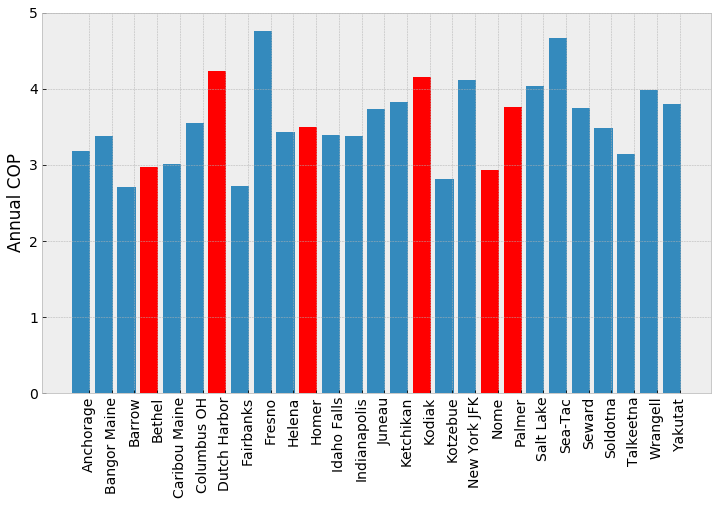

In [15]:
mod = HPmodel()

hp = df[df.ahri == 8703507].squeeze()
#hp = df[df.ahri == 8703348].squeeze()
mod.heat_pump = hp

LOAD_QUANTILE = 0.2
mod.oil_effic = 0.8
mod.elec_price = 0.166
mod.oil_price = 2.77
mod.balance_temp = 60
print(mod)
cities = []
cops = []
design_temps = []
temps_q = []
for wx_file in glob('data/*.csv'):
    city = os.path.splitext(os.path.basename(wx_file))[0]
    mod.city = city
    #find_size(mod, 600)
    mod.load_slope = 350
    res = mod.calculate()
    cities.append(city)
    cops.append(res['annual_cop'])
    design_temps.append(res['design_temp'])
    temps_q.append(mod.load_temp_quantile(LOAD_QUANTILE))
    print(
        '%s: COP=%.2f, Resid Oil=%.0f, Oil Only=%.0f, Design %.0f btu/hr @ %.0f F' % \
        (city, res['annual_cop'], res['oil_with_hp_gal'], res['oil_only_gal'], res['design_load'], res['design_temp'])
    )

ind = np.arange(len(cities))  # the x locations for the groups
width = 0.35       # the width of the bars
ax = gca()
ax.set_xticks(ind + width)
ax.set_xticklabels(cities, rotation='vertical')
bar(ind, cops)
region4_ixs = [3, 6, 10, 15, 18, 19]
region4_cops = [cops[ix] for ix in region4_ixs]
bar(region4_ixs, region4_cops, color='r')
ylabel('Annual COP')

Text(0,0.5,'Annual COP')

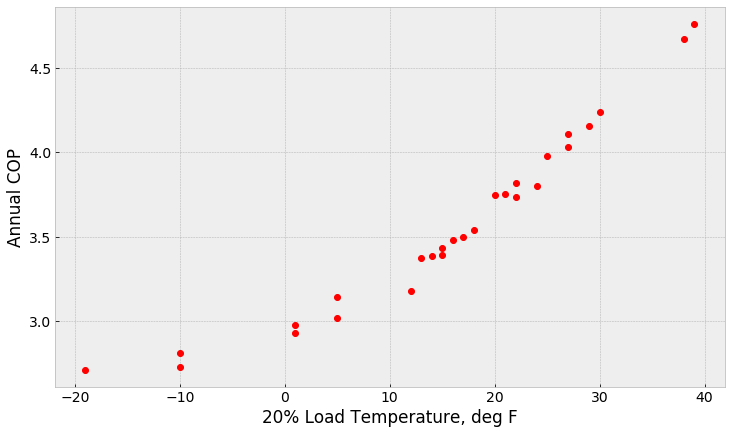

In [14]:
# 20th Percentile Load Temperature seems to correlate the best.
# Would be worth trying the average of the Outdoor Temperature implied
# by heating degree days and the Design Temperature.
plot(temps_q, cops, 'ro')
xlabel('%.0f%% Load Temperature, deg F' % (LOAD_QUANTILE * 100.0))
ylabel('Annual COP')

City: Seward
Heat Pump: None
Balance Temperature: 60.0 deg F
Load Slope: 800 Btu/hr-degF
Base Load: 0 Btu/hr
Electricity Price $0.160 / kWh
Oil Price: $2.70 / gallon
Oil Efficiency: 80.0%
Oil Btus: 135000 Btu/gallon

'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'
'<' not supported between instances of 'numpy.ndarray' and 'str'


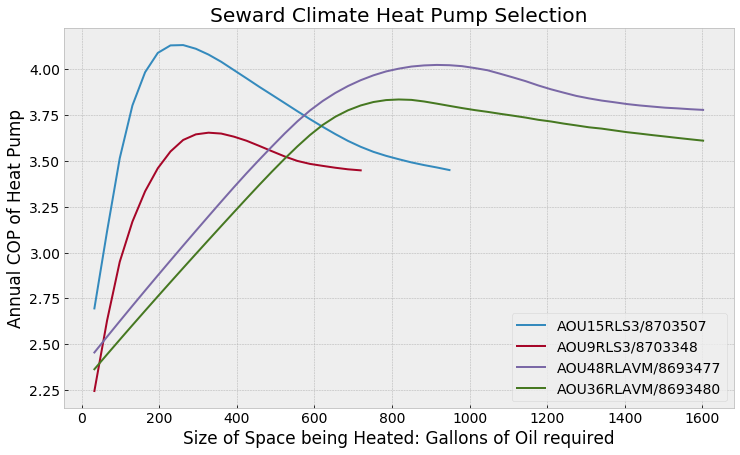

In [17]:
hps = [
    (df[df.ahri == 8703507], '-'),
    #(df[df.ahri == 5751312], '-'),
    #(df[df.ahri == 5751314], '-'),
    #(df[df.ahri == 8703350], '-'),
    (df[df.ahri == 8703348], '-'),
    (df[df.ahri == 8693477], '-'),
    (df[df.ahri == 8693480], '-'),
    (df[df.ahri == 8861565], '--'),
    (df[df.ahri == 9571162], '--'),
    (df[df.ahri == 8860533], '--'),
    (df[df.ahri == 10221199], '--'),
]
hps = [(d.squeeze(), ls) for d, ls in hps]

mod = HPmodel()
mod.city = 'Seward'
mod.oil_effic = 0.8
mod.elec_price = 0.16
mod.oil_price = 2.70
mod.balance_temp = 60
print(mod)

for the_hp, ls in hps:
    try:
        mod.heat_pump = the_hp
        tot_oil = []
        ann_cop = []
        for slope in np.arange(20, 1000, step=20):
            mod.load_slope = slope
            res = mod.calculate()
            if res['oil_with_hp_gal'] < 0.05 * res['oil_only_gal']:
                tot_oil.append(res['oil_only_gal'])
                ann_cop.append(res['annual_cop'])
        lbl = '%s/%s' % (the_hp.out_model, the_hp.ahri)
        plot(tot_oil, ann_cop, label=lbl, linestyle=ls)
    except Exception as e:
        print(e)
xlabel('Size of Space being Heated: Gallons of Oil required')
ylabel('Annual COP of Heat Pump')
#annotate('%s Climate' % mod.city, xy=(.7, .3), xycoords='figure fraction')
title('%s Climate Heat Pump Selection' % mod.city)
legend(fontsize='medium')

[]

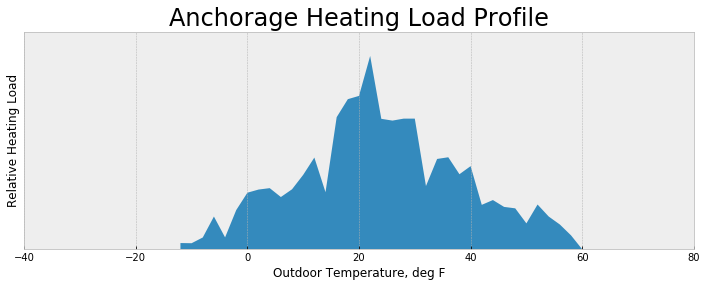

In [16]:
mod.city = 'Anchorage'
mod.load_slope = 500
mod.balance_temp = 60

temps = []
loads = []
for t, hrs in mod.temp_bins:
    temps.append(t)
    load = mod.calc_load(t)
    loads.append( load * hrs)

loads = np.array(loads) / 8760.
figure(figsize=(12,4))
stackplot(temps, loads)
xlabel('Outdoor Temperature, deg F')
ylabel('Relative Heating Load')
xlim(-40, 80)
ylim(0, 1000)
title('%s Heating Load Profile' % mod.city, fontsize=24)
gca().axes.get_yaxis().set_ticks([])

In [21]:
# Test each point on the spec curve to see if it matches specs
mod = HPmodel()
hp = df[df.ahri == 8703507].squeeze()
mod.heat_pump = hp

for t, pts in mod.specs:
    for ld, cop in pts:
        print(t, ld, cop, mod.hp_performance(t, ld)[1])
        

-5 0.0 1.66 1.577
-5 2388.0 3.33 3.1635
-5 18500.0 1.98 1.9546291273584908
5 0.0 1.88 1.7859999999999998
5 2696 3.76 3.5719999999999996
5 20500 2.18 2.1574145697596046
17 0.0 2.05 1.9474999999999998
17 2798 4.1 3.8949999999999996
17 11200 3.14 2.983
17 21500 2.43 2.378896844660194
47 0.0 2.67 2.67
47 3100 5.34 5.34
47 18000 4.59 4.59
47 23900 3.2 3.2


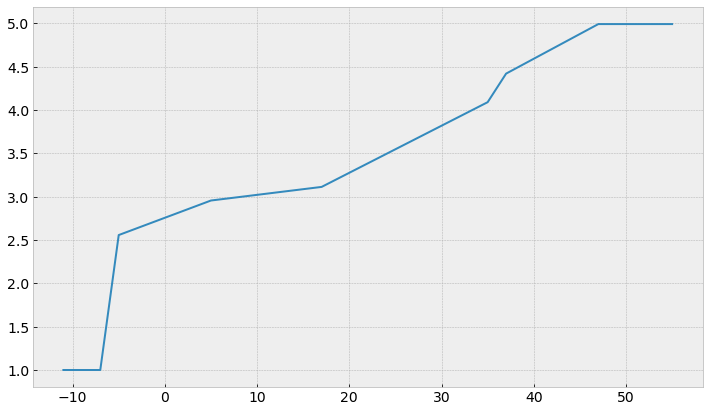

In [22]:
# test every 2 degrees from -11 to 55 at 10,000 Btu/hour load
temps = np.arange(-11.0, 56.0, step=2.0)
cops = [mod.hp_performance(t, 10000)[1] for t in temps]
plot(temps, cops)